In [34]:
import pickle
import sys, os
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn import cross_validation
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import pandas
import random
from PIL import Image
import csv
import numpy as np
from alexnet import AlexNet
#Keras modules
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as k
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Convolution2D, Cropping2D
# from keras.layers.core import Dense, Dropout, Activation, Flatten, Lambda, Cropping2D
# from keras.layers.core import Dense, Activation, Flatten, Dropout, Lambda
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.advanced_activations import ELU
from keras.regularizers import l2, activity_l2
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, Callback

In [35]:
lines =[]
with open('data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        lines.append(line)


In [36]:
#Training data
images = []
measurements =[]
for line in lines[1:]:
    source_path = line[0]
    filename = source_path.split('/')[-1]
    current_path = 'data/IMG/' + filename
    image =mpimg.imread(current_path)
    images.append(image)
    measurement = float(line[3])
    measurements.append(measurement)
    images.append(np.fliplr(image))
    measurements.append(measurement*-1.0)
X_train = np.array(images)
y_train = np.array(measurements)

(160, 320, 3)


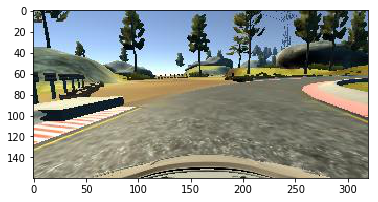

In [37]:
#Testing training data
print(images[1].shape)
plt.imshow(np.array(np.fliplr(images[50]).squeeze()))
plt.show()

In [38]:
features = tf.placeholder(tf.float32, (None, 160, 320, 3))
labels = tf.placeholder(tf.int64, None)
resized = tf.image.resize_images(features, (227, 227))

In [39]:
# create the base pre-trained model
fc7 = AlexNet(resized, feature_extract=True)

c7 = tf.stop_gradient(fc7)
shape = (fc7.get_shape().as_list()[-1], 3)
fc8W = tf.Variable(tf.truncated_normal(shape, stddev=1e-2))
fc8b = tf.Variable(tf.zeros(3))
logits = tf.nn.xw_plus_b(fc7, fc8W, fc8b)

In [49]:
# model architecture
model = Sequential()
model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(160,320,3)))
model.add(Cropping2D(cropping=((50,20), (0,0))))
model.add(Convolution2D(24,5,5, subsample=(2,2), activation='relu'))
model.add(Convolution2D(36,5,5, subsample=(2,2), activation='relu'))
model.add(Convolution2D(48,5,5, subsample=(2,2), activation='relu'))
model.add(Convolution2D(64,3,3, activation='relu'))
model.add(Convolution2D(64,3,3, activation='relu'))
model.add(Flatten())
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
model.fit(X_train,y_train, validation_split=0.2,batch_size=32,shuffle=True, nb_epoch=3)
model.save('model.h5')


Train on 12857 samples, validate on 3215 samples
Epoch 1/3
12857/12857 [==============================] - 134s - loss: 0.0122 - val_loss: 0.0113
Epoch 2/3
12857/12857 [==============================] - 134s - loss: 0.0098 - val_loss: 0.0101
Epoch 3/3
12857/12857 [==============================] - 135s - loss: 0.0094 - val_loss: 0.0112
